In [1]:
from configparser import RawConfigParser
import logging
from pathlib import Path

import httpx
from httpx_caching import CachingClient
from httpx_caching._heuristics import ExpiresAfterHeuristic

import uscensus
from uscensus import SqlAlchemyDataStore, get_county_boundaries, get_state_boundaries

In [2]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('uscensus.data').setLevel(logging.DEBUG)
#logging.getLogger('uscensus.util.webcache').setLevel(logging.DEBUG)
#logging.getLogger('httpx').setLevel(logging.DEBUG)

In [3]:
cp = RawConfigParser()

In [4]:
cp.read(Path('~/.census').expanduser())

['/home/nkrishna/.census']

In [5]:
client = CachingClient(httpx.Client(follow_redirects=True),
                       cacheable_status_codes=(200,203,300,301,302,308),
                       heuristic=ExpiresAfterHeuristic(days=7),
                       cache=SqlAlchemyDataStore('sqlite:///testing.db'))

In [6]:
%%time
cl = uscensus.DiscoveryInterface(
            cp.get('census','api_key'),
            client, 
            vintage='2021/acs/acs5')

DEBUG:uscensus.data.discovery:Fetching root metadata
DEBUG:uscensus.data.discovery:Fetching per-dataset metadata
DEBUG:uscensus.data.discovery:Processing dataset 2021/acs/acs5
DEBUG:uscensus.data.discovery:Finished processing metadata for dataset: http://api.census.gov/data/2021/acs/acs5
DEBUG:uscensus.data.discovery:Processing dataset 2021/acs/acs5/cprofile
For more information check: https://httpstatuses.com/404
DEBUG:uscensus.data.discovery:Finished processing metadata for dataset: http://api.census.gov/data/2021/acs/acs5/cprofile
DEBUG:uscensus.data.discovery:Processing dataset 2021/acs/acs5/profile
For more information check: https://httpstatuses.com/404
DEBUG:uscensus.data.discovery:Finished processing metadata for dataset: http://api.census.gov/data/2021/acs/acs5/profile
DEBUG:uscensus.data.discovery:Processing dataset 2021/acs/acs5/subject
ERROR:uscensus.util.webcache:[Errno -3] Temporary failure in name resolution
Traceback (most recent call last):
  File "/home/nkrishna/minic

CPU times: user 5.98 s, sys: 364 ms, total: 6.35 s
Wall time: 3min 9s


In [7]:
results = cl.search('"acs 5 detailed tables"')
results

,score,dataset_id,title,description
0,-1.540482,http://api.census.gov/data/2021/acs/acs5,American Community Survey: 5-Year Estimates: D...,The American Community Survey (ACS) is an ongo...


In [8]:
acs = cl[results.loc[0, 'dataset_id']]
acs

American Community Survey: 5-Year Estimates: Detailed Tables 5-Year

In [9]:
acs.endpoint

'http://api.census.gov/data/2021/acs/acs5'

In [10]:
acs.geographies

,scheme,name,predicate_type,referenceDate,requires,optionalWithWCFor,wildcard
0,fips,us,NaN,2021-01-01,NaN,NaN,NaN
1,fips,region,NaN,2021-01-01,NaN,NaN,NaN
2,fips,division,NaN,2021-01-01,NaN,NaN,NaN
3,fips,state,NaN,2021-01-01,NaN,NaN,NaN
4,fips,county,NaN,2021-01-01,[state],state,[state]
...,...,...,...,...,...,...,...
82,fips,public use microdata area,NaN,2021-01-01,[state],state,[state]
83,fips,zip code tabulation area,NaN,2021-01-01,NaN,NaN,NaN
84,fips,school district (elementary),NaN,2021-01-01,[state],state,[state]
85,fips,school district (secondary),NaN,2021-01-01,[state],state,[state]


In [11]:
acs.groups

,descriptions,variables
B17015,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...,"[B17015_047MA, B17015_047EA, B17015_046EA, B17..."
B18104,SEX BY AGE BY COGNITIVE DIFFICULTY,"[B18104_002EA, B18104_001MA, B18104_003EA, B18..."
B17016,POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...,"[B17016_003MA, B17016_003EA, B17016_004MA, B17..."
B18105,SEX BY AGE BY AMBULATORY DIFFICULTY,"[B18105_033MA, B18105_033EA, B18105_032MA, B18..."
B17017,POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEH...,"[B17017_046EA, B17017_046MA, B17017_047EA, B17..."
...,...,...
B99131,ALLOCATION OF MARITAL STATUS FOR FEMALES 15 TO...,"[B99131_003EA, B99131_002EA, B99131_001EA, B99..."
B09018,RELATIONSHIP TO HOUSEHOLDER FOR CHILDREN UNDER...,"[B09018_001E, B09018_001M, B09018_003E, B09018..."
B09019,HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY REL...,"[B09019_008EA, B09019_008MA, B09019_007EA, B09..."
B99132,ALLOCATION OF FERTILITY OF WOMEN 15 TO 50 YEARS,"[B99132_001EA, B99132_002EA, B99132_003EA, B99..."


In [12]:
vars = acs.searchVariables('"median gross rent"')
vars.head()

,score,variable,group,label,concept
0,-11.593395,B25064_001E,B25064,Estimate!!Median gross rent,MEDIAN GROSS RENT (DOLLARS)
1,-11.401724,B25031_001E,B25031,Estimate!!Median gross rent --!!Total:,MEDIAN GROSS RENT BY BEDROOMS
2,-11.216288,B25031_002E,B25031,Estimate!!Median gross rent --!!Total:!!No bed...,MEDIAN GROSS RENT BY BEDROOMS
3,-11.216288,B25031_006E,B25031,Estimate!!Median gross rent --!!Total:!!4 bedr...,MEDIAN GROSS RENT BY BEDROOMS
4,-11.216288,B25031_005E,B25031,Estimate!!Median gross rent --!!Total:!!3 bedr...,MEDIAN GROSS RENT BY BEDROOMS


In [13]:
med_rent_by_county = acs(['B25064_001E'], geo_for={'county': '*'})
med_rent_by_county.set_index(['state', 'county'], inplace=True)
med_rent_by_county.sort_index(inplace=True)
med_rent_by_county

B25064_001E
state county             
01    001            1085
      003            1093
      005             605
      007             744
      009             691
...                   ...
72    145             539
      147             470
      149             448
      151             479
      153             429

[3221 rows x 1 columns]

In [14]:
acs.vintage

2021

In [15]:
%matplotlib inline

In [16]:
import matplotlib.pyplot as plt
import fiona
import geopandas as gpd
import shapely

In [17]:
%%time
counties_df = get_county_boundaries(client)
states_df = get_state_boundaries(client)

CPU times: user 187 ms, sys: 694 µs, total: 188 ms
Wall time: 187 ms


In [18]:
counties_df = counties_df.rename(
    columns={'STATEFP': 'state', 'COUNTYFP': 'county'}
).set_index(['state', 'county'])
states_df = states_df.rename(
    columns={'STATEFP': 'state'}
).set_index('state')

<AxesSubplot: >

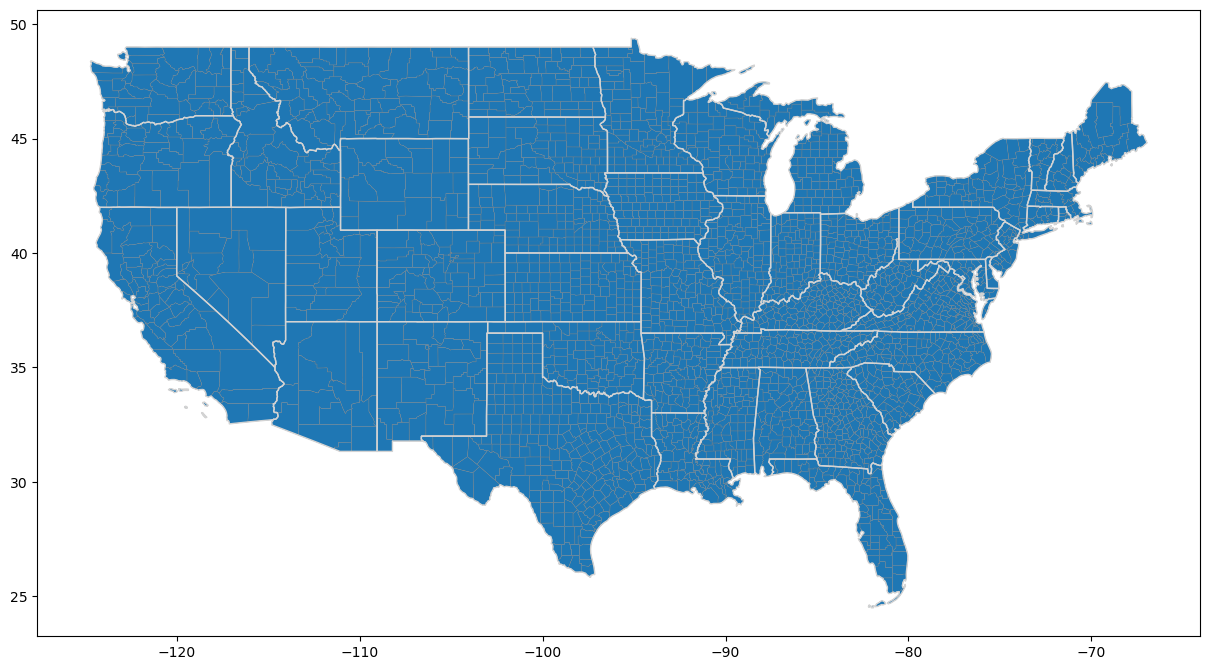

In [19]:
continental_bbox = shapely.geometry.box(-125.0011, 24.44, -66.9326, 49.5904)
continental_df = counties_df[counties_df.geometry.within(continental_bbox)]
states_df = states_df[states_df.geometry.intersects(continental_df.unary_union)]
ax = continental_df.plot(figsize=((15,15)), linewidth=0.25, edgecolor='gray')
states_df.plot(figsize=((15,15)), linewidth=1, edgecolor='lightgray', color=(1,1,1, 0), ax=ax)

In [20]:
counties_df.head(1)

,,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
state,county,,,,,,,,,,,
13,239,00350547,0500000US13239,13239,Quitman,Quitman County,GA,Georgia,06,391703076.0,24158295.0,"MULTIPOLYGON (((-85.14183 31.83926, -85.11403 ..."


In [21]:
%time
joined = continental_df.join(med_rent_by_county)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.29 µs


In [22]:
print(counties_df.shape)
print(continental_df.shape)
print(joined.shape)

(3221, 11)
(3108, 11)
(3108, 12)


In [23]:
special = joined['B25064_001E']==-666666666
joined = joined[~special]

<AxesSubplot: title={'center': 'American Community Survey: 5-Year Estimates: Detailed Tables 5-Year\nEstimate!!Median gross rent'}>

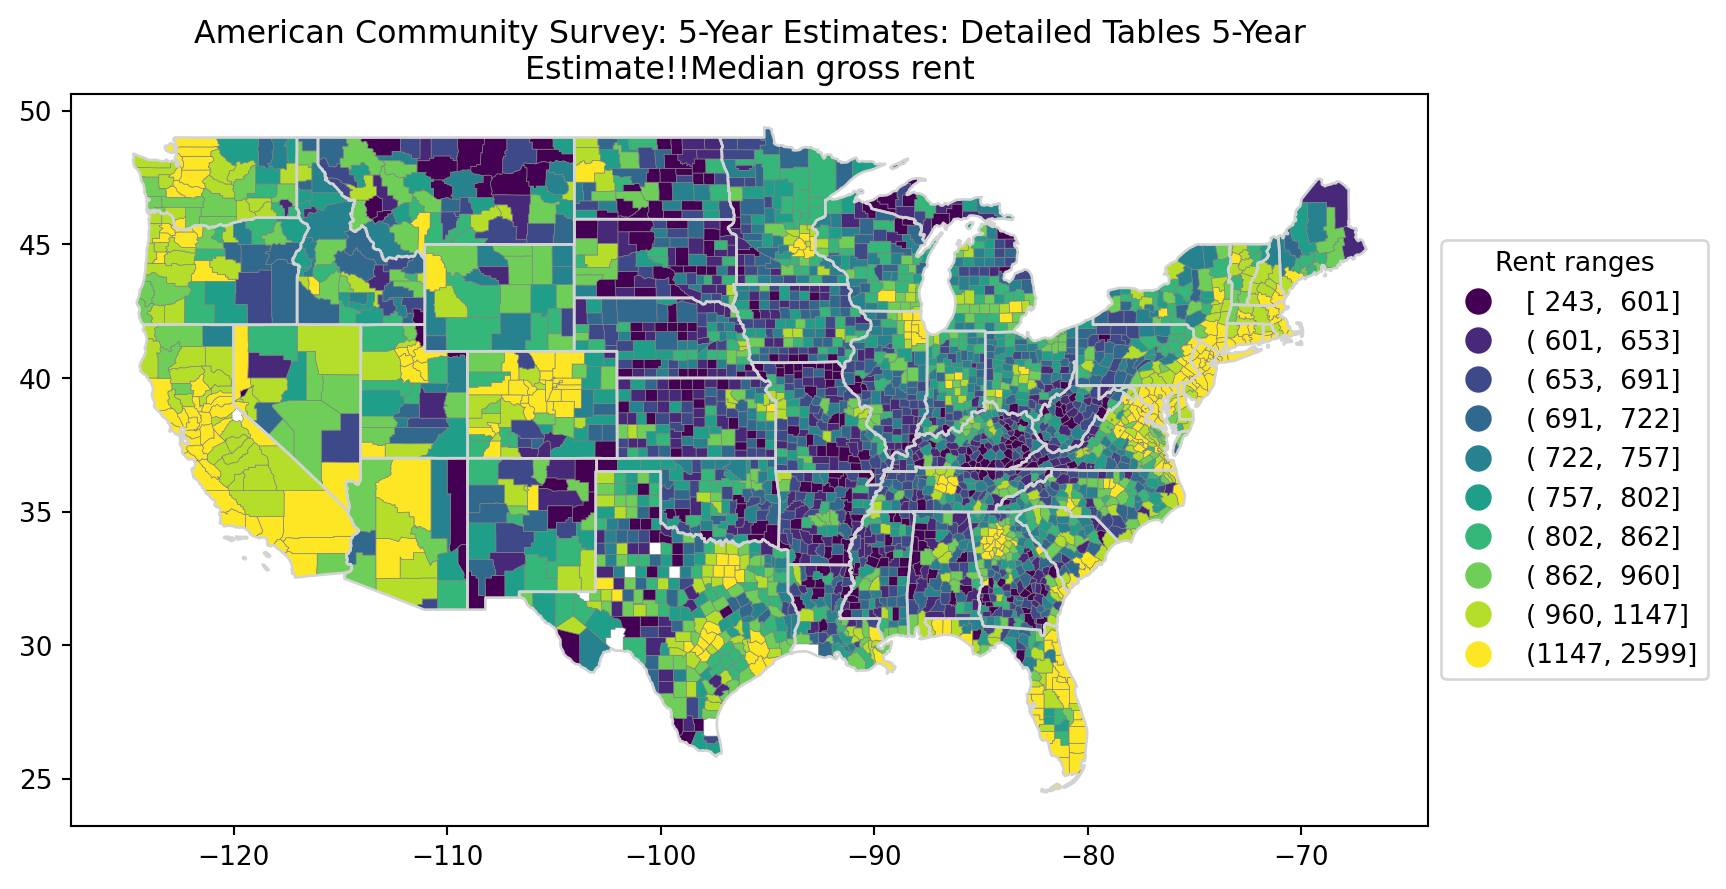

In [24]:
axes=joined.plot(
    column='B25064_001E', 
    scheme='quantiles',
    k=10,
    figsize=(15,5),
    edgecolor='gray',
    linewidth=0.25,
    legend=True,
    legend_kwds={
        'title': 'Rent ranges',
        'loc': 'center left',
        'bbox_to_anchor':(1,0.5),
        'fmt': '{:.0f}',
        'interval': True
    })
axes.figure.dpi=190
axes.set_title(f'{acs.title}\n{acs.variables_["B25064_001E"]["label"]}')
states_df.plot(figsize=((15,15)), linewidth=1, edgecolor='lightgray', color=(1,1,1, 0), ax=axes)
axes